In [2]:
from sentinelhub import BBox, CRS, MimeType, CustomUrlParam
import numpy as np
import datetime

In [3]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.core import EOPatch, FeatureType, EOWorkflow
from eolearn.features import SimpleFilterTask
from eolearn.io import S2L1CWCSInput

In [4]:
roi_bbox = BBox(bbox=[-4.152836, 37.067857, -4.102112, 37.048973], crs=CRS.WGS84)
time_interval = ('2016-01-01', '2018-01-01')

In [5]:
class MaxCCPredicate:
    def __init__(self, maxcc):
        self.maxcc = maxcc

    def __call__(self, img_cm):
        w, h, _ = img_cm.shape
        cc = np.sum(img_cm) / (w * h)
        return cc <= self.maxcc

In [6]:
wcs_task = S2L1CWCSInput(layer='BANDS-S2-L1C', 
                         resx='20m',
                         resy='20m',
                         time_difference=datetime.timedelta(hours=2))

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m',
                           cm_size_x='60m', 
                           cmask_feature='clm', 
                           cprobs_feature='clp')

filter_task = SimpleFilterTask((FeatureType.MASK, 'clm'), MaxCCPredicate(maxcc=0.05))

In [7]:
images = EOWorkflow.make_linear_workflow(wcs_task, add_clm, filter_task)

In [8]:
result = images.execute({wcs_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

In [9]:

eopatch_clean, = [result[key] for key in result.keys()]

In [10]:
import imageio, os
def make_gif(eopatch, project_dir, filename, fps):
    """
    Generates a GIF animation from an EOPatch.
    """
    with imageio.get_writer(os.path.join(project_dir, filename), mode='I', fps=fps) as writer:
            for image in eopatch:
                writer.append_data(np.array(image[..., [3, 2, 1]], dtype=np.uint8))

In [11]:
make_gif(eopatch=eopatch_clean.data['BANDS-S2-L1C']*2.5*255, project_dir='.', filename='eopatch_clean_clip.gif', fps=3)

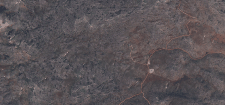

In [12]:
from IPython.display import Image

Image(filename="eopatch_clean_clip.gif")